# Libraries Required

In [19]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import json

%matplotlib inline

# Importing Open Pose

In [20]:
MODE = "MPI"

if MODE is "COCO":
    protoFile = "pose/coco/pose_deploy_linevec.prototxt"
    weightsFile = "pose/coco/pose_iter_440000.caffemodel"
    nPoints = 18
    POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13],[0,14],[0,15],[14,16],[15,17]]

elif MODE is "MPI" :
    protoFile = "pose/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
    weightsFile = "pose/mpi/pose_iter_160000.caffemodel"
    nPoints = 15
    POSE_PAIRS = [[0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7], [1,14], [14,8], [8,9], [9,10], [14,11], [11,12], [12,13] ]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

inWidth = 368
inHeight = 368

# Importing Ideal Poses

In [21]:
f = open("AngleValues/angles.json")
angle_dict = json.load(f)
f = open("AngleValues/poseIndices.json")
pose_indices_dict = json.load(f)

In [22]:
print(angle_dict)
print(" ")
print(pose_indices_dict)

{'Goddess': {'elbow-l': 90, 'elbow-r': -87.27368900609373, 'knee-l': 74.05460409907715, 'knee-r': 62.10272896905237, 'kneck-l': 63.43494882292201, 'kneck-r': 56.309932474020215, 'leg-l': 52.25319461272534, 'leg-r': -49.76364169072618, 'back': 0}, 'Tree': {'elbow-l': 38.24748654569379, 'elbow-r': -9.673355432403495, 'knee-l': 33.52447324857696, 'knee-r': 10.66034829453531, 'kneck-l': 71.83404347077447, 'kneck-r': 71.83404347077447, 'leg-l': 39.82542125282, 'leg-r': 14.036243467926468, 'back': 7.125016348901795}, 'Warrior2': {'elbow-l': -7.431407971172507, 'elbow-r': 0.0, 'knee-l': 66.80140948635182, 'knee-r': -12.986919108892511, 'kneck-l': 46.548157698977974, 'kneck-r': 66.03751102542182, 'leg-l': 36.660023934276474, 'leg-r': -13.665125023942625, 'back': 10.40771131249005}}
 
{'elbow-l': [2, 3, 4], 'elbow-r': [5, 6, 7], 'knee-l': [8, 9, 10], 'knee-r': [11, 12, 13], 'kneck-l': [0, 1, 2], 'kneck-r': [0, 1, 5], 'leg-l': [14, 8, 9], 'leg-r': [14, 11, 12], 'back': [0, 1, 14]}


# Running open pose on new image

In [23]:
test_dir = 'scoringTest'
img_address = []
for img in os.listdir(test_dir):
    img_address.append(test_dir + '/' + img)
    print(img_address)

['scoringTest/00000154.jpg']


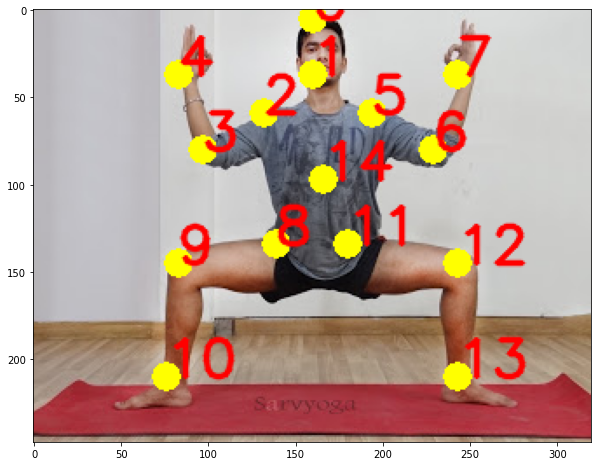

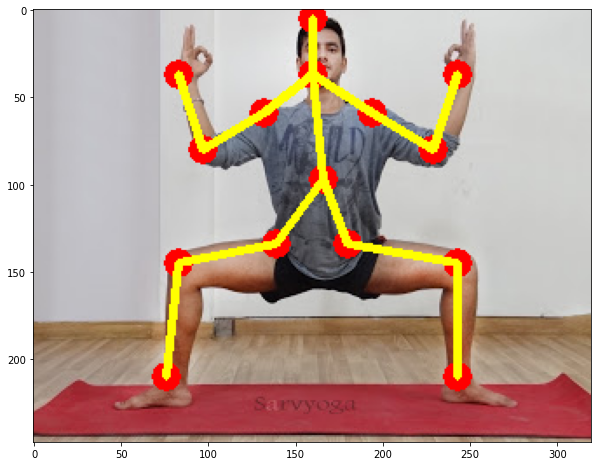

In [24]:
pose_coordinates = []
for img in img_address:
    frame = cv2.imread(img)
    frameCopy = np.copy(frame)
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    threshold = 0.1
    inpBlob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (inWidth, inHeight),
                                      (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    H = output.shape[2]
    W = output.shape[3]
    points = []
    for i in range(nPoints):
        # confidence map of corresponding body's part.
        probMap = output[0, i, :, :]

        # Find global maxima of the probMap.
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        # Scale the point to fit on the original image
        x = (frameWidth * point[0]) / W
        y = (frameHeight * point[1]) / H
        if prob > threshold : 
            cv2.circle(frameCopy, (int(x), int(y)), 8, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frameCopy, "{}".format(i), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, lineType=cv2.LINE_AA)
            cv2.circle(frame, (int(x), int(y)), 8, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
            # Add the point to the list if the probability is greater than the threshold
            points.append((int(x), int(y)))
        else :
            points.append(None)
        
    pose_coordinates.append(points)
    # Draw Skeleton
    for pair in POSE_PAIRS:
        partA = pair[0]
        partB = pair[1]

        if points[partA] and points[partB]:
            cv2.line(frame, points[partA], points[partB], (0, 255, 255), 3)
    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB))
    plt.figure(figsize=[10,10])
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    

# Evaluating theta matrices

In [25]:
pose_coordinates

[[(160, 5),
  (160, 37),
  (132, 59),
  (97, 80),
  (83, 37),
  (194, 59),
  (229, 80),
  (243, 37),
  (139, 134),
  (83, 145),
  (76, 210),
  (180, 134),
  (243, 145),
  (243, 210),
  (166, 97)]]

In [26]:
pose_name = 'Goddess' #Imagine that the pose name is derived post classification

In [27]:
print(angle_dict[pose_name])

{'elbow-l': 90, 'elbow-r': -87.27368900609373, 'knee-l': 74.05460409907715, 'knee-r': 62.10272896905237, 'kneck-l': 63.43494882292201, 'kneck-r': 56.309932474020215, 'leg-l': 52.25319461272534, 'leg-r': -49.76364169072618, 'back': 0}


In [28]:
def calculate_angle(indices, coordinates):
    p1 = coordinates[indices[0]]
    p2 = coordinates[indices[1]]
    p3 = coordinates[indices[2]]
    if(p3[0] - p2[0] == 0 and p2[0] - p1[0] == 0):
        return 0
    if(p2[0] - p1[0] == 0):
        m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
        return (90 - math.degrees(math.atan(m2)))
    if(p3[0] - p2[0] == 0):
        m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
        return (90 - math.degrees(math.atan(m1)))
    m1 = (p2[1] - p1[1])/(p2[0] - p1[0])
    m2 = (p3[1] - p2[1])/(p3[0] - p2[0])
    if(m1 * m2 == -1):
        theta = 90
    else:
        tan_theta = (m2-m1)/(1 + m1 * m2)
        theta = math.degrees(math.atan(tan_theta))
    return theta

In [29]:
store_dict = {}
for k in  pose_indices_dict:
    store_dict[k] = calculate_angle(pose_indices_dict[k], pose_coordinates[0])        
print(store_dict)

{'elbow-l': -77.07052903505634, 'elbow-r': 77.07052903505634, 'knee-l': -72.74033380440504, 'knee-r': 80.09581678702612, 'kneck-l': 128.15722658736905, 'kneck-r': 57.0947570770121, 'leg-l': 42.767618614571944, 'leg-r': -59.37025792146559, 'back': 5.710593137499629}


In [31]:
for joint in store_dict:
    if abs(store_dict[joint]) > 90:
        store_dict[joint] = 180 - abs(store_dict[joint])

In [32]:
diff_matrix = []
for joint in store_dict:
    diff_matrix.append(abs(abs(angle_dict[pose_name][joint]) - abs(store_dict[joint])))

In [33]:
diff_matrix

[12.929470964943661,
 10.203159971037394,
 1.314270294672113,
 17.993087817973752,
 11.592175410291063,
 0.7848246029918826,
 9.485575998153394,
 9.606616230739405,
 5.710593137499629]

In [35]:
diff_avg = sum(diff_matrix)/len(diff_matrix)
print(diff_avg)

8.846641603144699


In [36]:
if diff_avg < 5:
    print(10)
elif diff_avg < 10:
    print(9)
elif diff_avg < 15:
    print(8)
elif diff_avg < 20:
    print(7)
else:
    print("Please make a better attempt !")

9
